In [1]:
%load_ext autoreload
%autoreload 2
import ncxt_sxtcnn

In [2]:
from ncxt_sxtcnn.sxtcnn.loaders import AmiraLoaderx100
from ncxt_sxtcnn.sxtcnn.models import UNet3D
from ncxt_sxtcnn.sxtcnn.processors import RandomBlockProcessor
from ncxt_sxtcnn.sxtcnn.criteria import CrossEntropyLoss_DiceLoss

### Setup Database

In [3]:
from ncxt_sxtcnn.hxdatabase import Database
db = Database('mockdata/')
db.dataframe_sel('membrane')

mockdata/


C:\Users\axela\AppData\Roaming\Python\Python37\site-packages\pandas\core\ops\__init__.py:1115: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


,project,sample,void,void1,nucleus,nucleolus,granule,mitochondria,lipid,endoplasmic reticulum,membrane,ignore
0,pi1,sample_12,0,1,2,3,4,5,6,7,8,9
1,pi2,sample_9,0,,1,5,,3,2,4,6,


In [4]:
membrane = ['membrane']
nucleus = ['euchromatin','heterochromatin','nucleus','nucleolus']
hxfiles = db.filelist(membrane,nucleus)
db.dataframe_sel(membrane,nucleus)

,project,sample,void,void1,nucleus,nucleolus,granule,mitochondria,lipid,endoplasmic reticulum,membrane,ignore
0,pi1,sample_12,0,1,2,3,4,5,6,7,8,9
1,pi2,sample_9,0,,1,5,,3,2,4,6,


### Full Database segmenation
- define task
- define loader+- define architecture+processor
- everything wrapped up in a factory + conveniecne class for the CNN controls

In [5]:
from ncxt_sxtcnn import Segmenter
files = db.filelist(membrane,nucleus)
features = [membrane,nucleus]
working_directory = 'C:/Users/axela/Documents/2020/example_wd/'

loader_args = {'files': files,
             'features': features}

processor_args = {'block_shape': (32, 32, 32),
                  'binning': 1,
                  }

model_args = {
    'num_classes':len(features)+1,
    'depth': 3,
    'start_filts': 32,
    'dropout': None,
    'instancenorm': True,
}
crit_args = dict()
settings = dict()

segmenter = Segmenter(AmiraLoaderx100, 
                      RandomBlockProcessor, 
                      UNet3D, 
                      CrossEntropyLoss_DiceLoss,
                      loader_args,
                      processor_args,
                      model_args,
                      crit_args,
                      settings,
                     )
segmenter.folder = working_directory
segmenter.fold =0
 

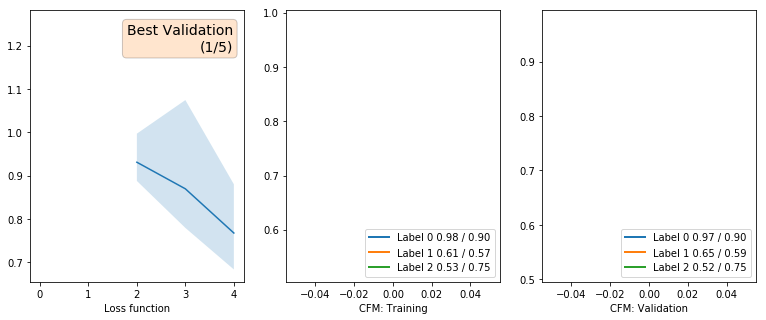

In [21]:
instance = segmenter.sxtcnn(0)
instance.run()
instance.logger.plot()

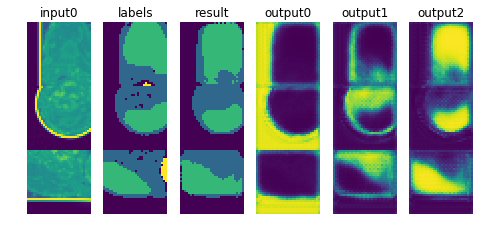

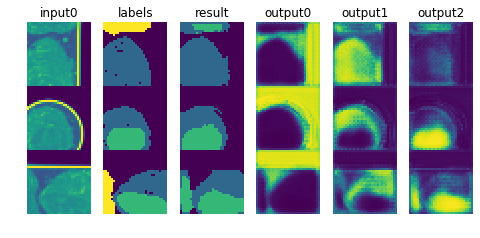

In [25]:
instance.show_training_data(0,'train')
instance.show_training_data(0,'validation')

### K-fold cross- validation

In [33]:
import numpy as np

from ncxtutils.sxtcnn.cnnutils import confusion_matrix_metric
def cfm_metric(cfm, metric):
    n, _ = cfm.shape
    metric = [confusion_matrix_metric(cfm, i, metric) for i in range(n)]
    return np.mean(metric[1:])

def mean_metrics(resdict, metric):
    metric_test = [cfm_metric(cfm, metric) for cfm in resdict.values()]
    weights = [1 / m for m in metric_test]
    return np.average(metric_test)
       

In [34]:
task_args = {'cellmask': True,
             'features': [],
             'working_directory': 'C:/Users/axela/Documents/2019/wd/'}
loader_args = {'binning': None,
               'norm': 100,
               }

model_args = {
    'depth': 3,
    'start_filts': 32,
    'dropout': None,
    'batchnorm': None,
}

processor_args = {'block_shape': (32, 32, 32),
                  'binning': 8, }

factory_args = {'init': True, 'reset': False, 'n_blocks': 2}
factory = SegFactory(db, **task_args)
factory.set_loader(NCXTDBLoader, **loader_args)
factory.set_model(UNet3D, **model_args)
factory.set_processor(RandomBlockProcessor, **processor_args)



In [35]:
def train_kfold(factory, kfold, **factory_args):
    cfm_fold = dict()
    for i in range(kfold):
        seg = factory.kfold(i,kfold, **factory_args)
        
        # train all networks to 100 iters
        try:
            seg.loadstate()
        except FileNotFoundError:
            print('Non state found, training')
            seg.run(n_epoch=100)
            seg.savestate() 

        for index in seg.test_idx:
            cfm_fold[index] = seg.evaluate_sample(seg.loader, index, plot=False)

    metrics = ['precision', 'recall', 'dice']
    mean_metric = [
        mean_metrics(cfm_fold, metric) for metric in metrics
    ]
    msg = [f'{m}: {val:.3f}' for m, val in zip(metrics, mean_metric)]
    print('Result ', msg)
    
    for k,v in cfm_fold.items():
        res = [f'{m}: {cfm_metric(v, m):.2f} ' for m in metrics]
        print(k,res)
        
    return cfm_fold

cfm_fold = train_kfold(factory, 3, **factory_args)

K-fold (3) training on train [1, 6, 0, 7, 11, 9, 8, 5] test [ 2  3  4 10] 
Init kfold
Data folder C:\Users\axela\Documents\2019\wd\data_RandomBlockProcessor_11983\train already exists
Non state found, training
Training for 100 epochs



model (511, 474, 511), target (511, 474, 511)
Label contains ignore mask (511, 474, 511)
K-fold (3) training on train [2, 3, 4, 10, 11, 9, 8, 5] test [1 6 0 7] 
Init kfold
Data folder C:\Users\axela\Documents\2019\wd\data_RandomBlockProcessor_52399\train already exists
Non state found, training
Training for 100 epochs



K-fold (3) training on train [2, 3, 4, 10, 1, 6, 0, 7] test [11  9  8  5] 
Init kfold
Data folder C:\Users\axela\Documents\2019\wd\data_RandomBlockProcessor_28985\train already exists
Non state found, training
Training for 100 epochs



model (465, 494, 465), target (465, 494, 465)
Label contains ignore mask (465, 494, 465)
Result  ['precision: 0.906', 'recall: 0.771', 'dice: 0.778']
2 ['precision: 0.97 ', 'recall: 0.88 ', 'dice: 0.92 ']
3 ['precision: 1.00 ', 'recall: 0.78 ', 'dice: 0.87 ']
4 ['precision: 0.87 ', 'recall: 0.97 ', 'dice: 0.92 ']
10 ['precision: 0.96 ', 'recall: 0.96 ', 'dice: 0.96 ']
1 ['precision: 0.78 ', 'recall: 0.06 ', 'dice: 0.11 ']
6 ['precision: 0.89 ', 'recall: 0.86 ', 'dice: 0.88 ']
0 ['precision: 0.90 ', 'recall: 0.04 ', 'dice: 0.08 ']
7 ['precision: 0.92 ', 'recall: 0.99 ', 'dice: 0.96 ']
11 ['precision: 0.93 ', 'recall: 0.95 ', 'dice: 0.94 ']
9 ['precision: 0.93 ', 'recall: 0.94 ', 'dice: 0.94 ']
8 ['precision: 0.90 ', 'recall: 0.86 ', 'dice: 0.88 ']
5 ['precision: 0.82 ', 'recall: 0.96 ', 'dice: 0.89 ']


K-fold (3) training on train [1, 6, 0, 7, 11, 9, 8, 5] test [ 2  3  4 10] 
K-fold (3) training on train [2, 3, 4, 10, 11, 9, 8, 5] test [1 6 0 7] 
K-fold (3) training on train [2, 3, 4, 10, 1, 6, 0, 7] test [11  9  8  5] 


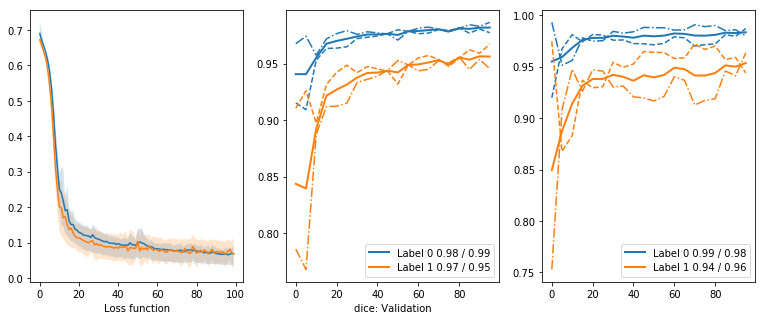

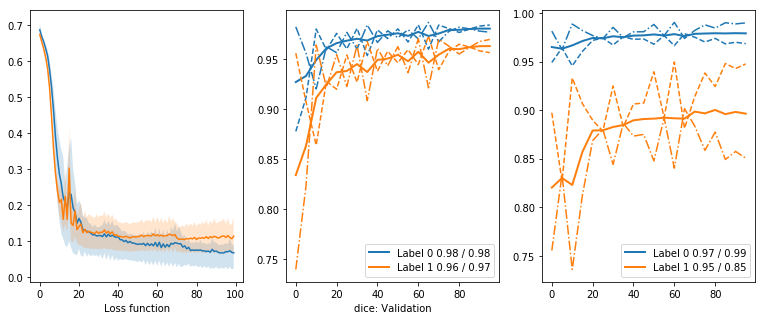

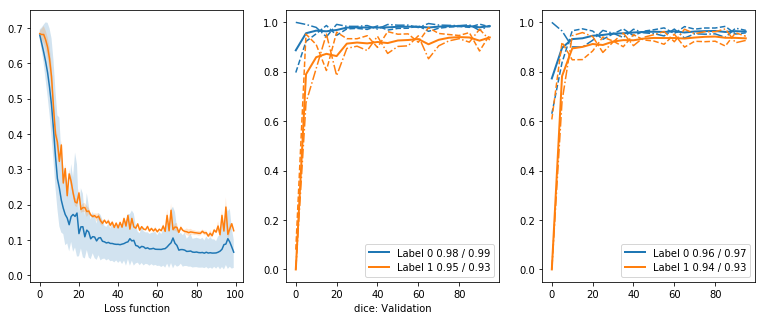

In [41]:
kfold = 3
for i in range(3):
    seg = factory.kfold(i, kfold)
    seg.loadstate()
    seg.plot_train()

## Convenience functions
The method 
``` python
def plot_example(self, index=0, mode="train"):
    ...
```
can be used to vizualize what is happewning to the training and validation data

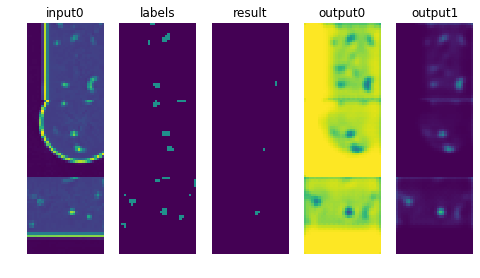

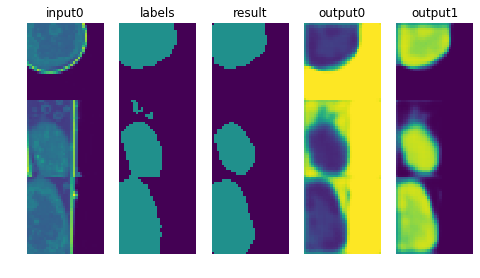

In [51]:
seg.plot_example(index = 12, mode = 'train')
seg.plot_example(index = 5, mode = 'valid')

``` python
def evaluate_sample(self, index, loader=None, plot=False):
    ...
```
is used to evaluate database entries

model (465, 494, 465), target (465, 494, 465)
Label contains ignore mask (465, 494, 465)


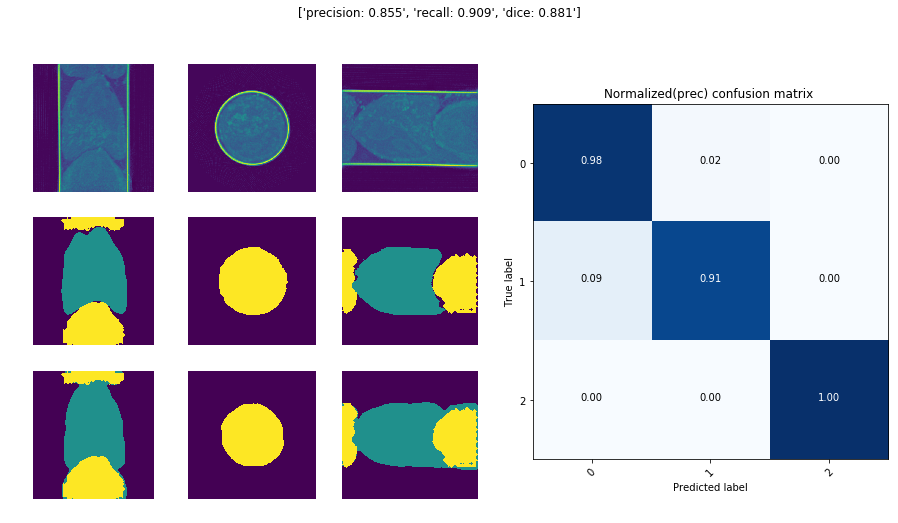

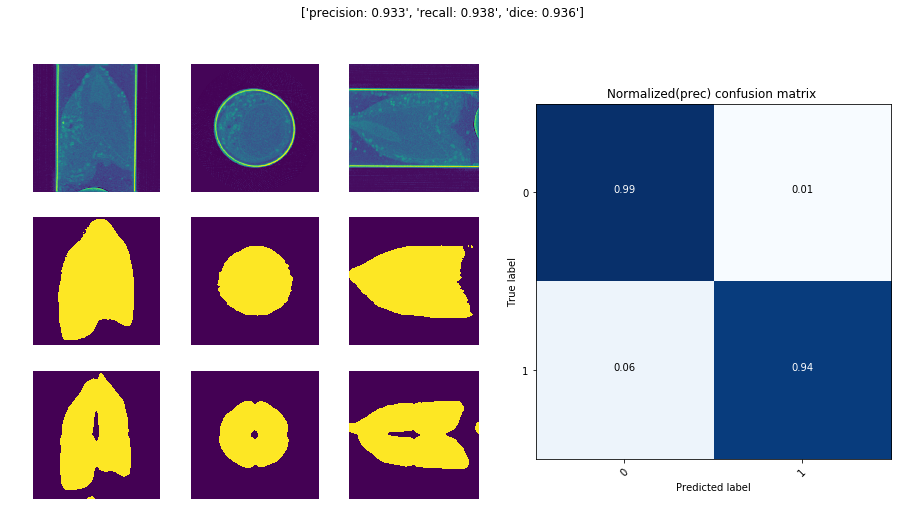

In [52]:
for index in seg.test_idx[:2]:
    _ = seg.evaluate_sample(index, plot=True)